### Ranking with Feature History (Section 6.2.2)
* Zweck: Verbesserung des Ranking Quotienten aus der Replikation anhand der Feature Hisotry Matrizen.
* Matrix: Regressionsmatrix mit Feautre History des mozilla-central Repository
* Features: Includes, Function Calls
* Modell: Support Vector Regressionsmodell

#### Setup
* Training-Set/Test-Set: Stratified sampling auf einer Matrix (2/3 : 1/3)

#### Results
Angenommen man möchte durch die Optimierung von 30 Komponenten soviele Verwundbarkeiten wie möglich beheben. Bei der Auswahl verlässt man sich auf die Vorhersage des Regressionsmodells. Das Skript teilt die Anzahl Verwundbarkeiten, die dabei tatsächlich behoben werden, durch die Anzahl, die maximal behoben werden könnten. Der Scatterplot zeigt die einzelnen Resultate für Includes und Function Calls bei 40 Experimenten. Die durchschnittlichen Werte und die Standardabweichung des Quotienten sind in der Tabelle aufgelistet.

0 - f_opt: 893.0, quotient: 0.987681970885
1 - f_opt: 821.0, quotient: 0.990255785627
2 - f_opt: 817.0, quotient: 0.992656058752
3 - f_opt: 865.0, quotient: 0.989595375723
4 - f_opt: 829.0, quotient: 0.977080820265
5 - f_opt: 846.0, quotient: 0.983451536643
6 - f_opt: 850.0, quotient: 0.988235294118
7 - f_opt: 895.0, quotient: 0.989944134078
8 - f_opt: 829.0, quotient: 0.985524728589
9 - f_opt: 829.0, quotient: 0.983112183353
10 - f_opt: 836.0, quotient: 0.988038277512
11 - f_opt: 854.0, quotient: 0.992974238876
12 - f_opt: 804.0, quotient: 0.980099502488
13 - f_opt: 925.0, quotient: 0.982702702703
14 - f_opt: 858.0, quotient: 0.981351981352
15 - f_opt: 795.0, quotient: 0.968553459119
16 - f_opt: 869.0, quotient: 0.968929804373
17 - f_opt: 877.0, quotient: 0.984036488027
18 - f_opt: 792.0, quotient: 0.978535353535
19 - f_opt: 825.0, quotient: 0.991515151515
20 - f_opt: 794.0, quotient: 0.981108312343
21 - f_opt: 817.0, quotient: 0.979192166463
22 - f_opt: 859.0, quotient: 0.97671711292

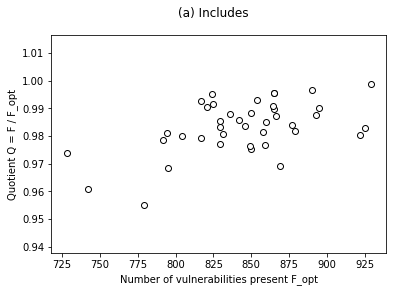

In [18]:
%matplotlib inline

from imports.matrix_helper import MatrixHelper
from imports.prediction_helper import PredictionHelper
import matplotlib.pyplot as plt
import numpy as np

matrix_helper = MatrixHelper()
experiments_count = 40

# read pickle
matrices = matrix_helper.load_from_parse('data/matrices/matrix_reg_incl_history.pickle')

quotient_list = []
f_opt_list = []
for i in range(experiments_count):
    # Instantiate Prediction Helper Class and predict values for compare matrix
    prediction_helper = PredictionHelper()
    prediction_helper.calculate_validation_compare_matrix(matrices, sampling_factor=(2.0/3), model_type='SVR')

    # get the compare matrix twice:
    # Once sorted according to the PREDICTED number of vulnerabilities
    # Once sorted according to the ACTUAL number of vulnerabilities
    compare_matrix_sorted_predicted = prediction_helper.get_compare_matrix_sorted()
    compare_matrix_sorted_actual = prediction_helper.get_compare_matrix_sorted(reference_column=2)

    # Crop first 30 Samples of both matrices
    relevant_samples_count = 30
    compare_matrix_sorted_predicted = compare_matrix_sorted_predicted[range(relevant_samples_count)]
    compare_matrix_sorted_actual = compare_matrix_sorted_actual[range(relevant_samples_count)]

    # Sum up the actual number of vulnerabilities in both matrices
    f = sum(np.array(compare_matrix_sorted_predicted[:, 2], dtype='f'))
    f_opt = sum(np.array(compare_matrix_sorted_actual[:, 2], dtype='f'))
    
    f_opt_list.append(f_opt)
    quotient_list.append(f / f_opt)
    print('{} - f_opt: {}, quotient: {}'.format(i, f_opt, f / f_opt))

# plot
fig = plt.figure()
plt.scatter(f_opt_list, quotient_list, edgecolor='black', linewidth='1', facecolor='white')
fig.suptitle('(a) Includes')
plt.xlabel('Number of vulnerabilities present F_opt')
plt.ylabel('Quotient Q = F / F_opt')
fig.savefig('outputs/f_opt-quotient-includes-history.pdf')

# print
quotient_average = sum(quotient_list) / float(len(quotient_list))
print('Average Quotient of {} Experiments: {}'.format(experiments_count, quotient_average)) 